# **Random Forests** #

**Classification**

**Imports**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

**Loading Dataset**

In [77]:
df = pd.read_csv("../../Datasets/Bank Customer Churn Prediction.csv")

df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Dropping Unnecessary columns** 

In [78]:
#Dropping customer_id as it doesnt have any effect on results 
df = df.drop("customer_id", axis=1)

In [79]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Handling Categorical Variables**

We will convert the gender into Binary using Label Encoder

In [80]:
#converting the value of column to 0 or 1
from sklearn.preprocessing import LabelEncoder

variables = ['gender']

encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

We will convert the country into Nominal variable using OneHotEncoder

In [81]:
from sklearn.preprocessing import OneHotEncoder

variables = ['country']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [82]:
df = df.drop("country_France", axis=1)
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


**Balancing Dataset**

we will balance the dataset to overcome the imbalance of minority class

In [83]:

from imblearn.over_sampling import SMOTE

X = df.drop('churn', axis=1)
y = df['churn']

smote = SMOTE(sampling_strategy=0.5, random_state=42)  
X_res, y_res = smote.fit_resample(X, y)




**Train/Test Split**

In [84]:
#Defining the dataset into X & Y 

X = df.drop(["churn"], axis=1)
y = df[["churn"]]

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42, stratify=y_res)


**RandomizedSearchCV**


we will use RandomizedSearchCV to find the best parameters quickly

In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

 # initialize testable parameters
 # Since we have to wrap LinearSVC into CalibratedClassifierCV
 # we have to use this estimator__ prefix in the parameters
param_dist = {
     'n_estimators': [25, 35, 40, 50, 60, 70, 75, 100],
     'max_depth': [3,4,5,6,7,8,9,10,11,12],
 }

 # start finding the optimal parameters with RandomizedSearchCV!
 # RandomizedSearchCV is usually way faster than GridSearchCV
 # .... but it's also mostly random
test_model = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1200, verbose=3, n_jobs=-1, cv=5, random_state=42)
test_model.fit(X_train, y_train)

c:\Users\stsaa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 80 is smaller than n_iter=1200. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 80 candidates, totalling 400 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=1200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12],
                                        'n_estimators': [25, 35, 40, 50, 60, 70,
                                                         75, 100]},
                   random_state=42, verbose=3)

In [100]:
test_model.best_params_

{'n_estimators': 100, 'max_depth': 12}

In [101]:
test_model.best_score_

0.8370160574698892

**Random Forest Model**

In [110]:
model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=12))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12))])

**Metrics**

In [111]:
#making test predictions 
predictions = model.predict(X_test)

# printing the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# getting overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1991
           1       0.79      0.69      0.73       995

    accuracy                           0.83      2986
   macro avg       0.82      0.80      0.81      2986
weighted avg       0.83      0.83      0.83      2986


Model overall accuracy: 83.36%


The metrics are much better compared to Logistic Regression and SVC and Random Forests is handling imbalance quite well too

[[1814  177]
 [ 307  688]]


<Axes: >

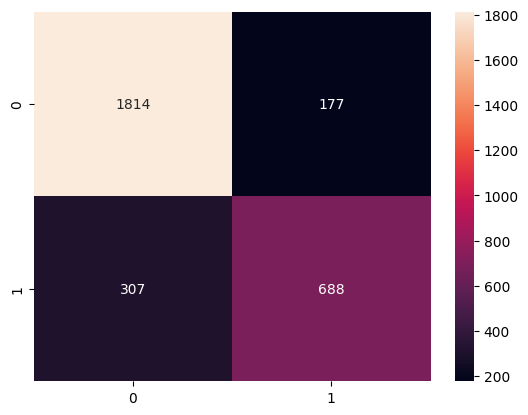

In [104]:
print(confusion_matrix(y_test, predictions))

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [105]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


0.9013894182110957

ROC AUC score of 0.90 shows that its performing better than previous models.

In [106]:
df.tail()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
9995,771,1,39,5,0.00,2,1,0,96270.64,0,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,1,0
9999,792,0,28,4,130142.79,1,1,0,38190.78,0,0,0


In [112]:
# Gender -column: 0 => Female, 1 => Male
tester_row = {
    'credit_score': 771,
    'gender': 1,
    'age': 39,
    'tenure': 5,
    'balance': 0.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 0,
    'estimated_salary': 96270.64,
    'country_Germany':0,
    'country_Spain':0

}

# creating a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this person churn (No/Yes):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.97715415 0.02284585]]

Did this person churn (No/Yes):
No
-------------------


**Summary**

We have imported all the libraries first then we imported the data and checked for duplicates and misssing values and dropped missing coloumn after that we converted non numerical variables such as gender and country as numerical values using LabelEncoder and OneHotEncoder. We balanced the dataset using SMOTE (Synthetic oversampling of minority class) and used RandomizedSearchGrid to find best parameters and  trained the model and checked metrics with previous model to compare and there was improvement in the balance of model and accuracy. ROC AUC for the model showed 90 which is good. Random Forest performed better than SVC and Logistic regression.


